In [1]:
import os
import time
import itertools
import random

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from torchvision.transforms import v2
import torch
from tqdm import tqdm

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# import mediapy as media

%matplotlib inline
%load_ext autoreload
%autoreload 2
from vae_model import *
from ph_dataset import *

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
# torchvision.disable_beta_transforms_warning()

/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2D1B8D5C-7891-3680-9CF9-F771AE880676> /Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <38796DC6-8F33-3A89-BBAA-5FC71F99817A> /Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints a

In [2]:
# Training helper functions
def make_training_loss_plot(log_dict, figsize=(9,6)):
    """Plot training loss vs step"""
    epoch = log_dict['Epoch'][-1]
    log_df = pd.DataFrame.from_dict(log_dict)
    plt.figure(figsize=figsize)
    sns.lineplot(
        log_df,
        x='Step',
        y='Loss',
        errorbar=None,
    )
    ax = plt.gca()
    ax.set_ylabel('Loss')
    ax.set_yscale('log')
    plt.grid(True, which="both", ls="-")
    plt.title(f'Training Loss After {epoch} Epochs')
    plt.show()

def get_device(verbose=False):
    """Returns the torch device to use for training based on detected gpu hardware."""
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    if verbose: print(f"Using device {device}")
    return device

def show_dataset_sample(dataset, nrows=5, ncols=15):
    """Preview images from the dataset."""
    nsamples = nrows * ncols
    idxs = np.arange(len(dataset))
    sample_idxs = np.random.choice(idxs, nsamples, replace=False)
    
    if len(sample_idxs) < nsamples:
        print('Not enough training data')

    f = plt.figure(figsize=(ncols, nrows))
    f.tight_layout()

    canvas = np.zeros((nrows * 16, ncols * 16))
    xy_indices = itertools.product(range(nrows), range(ncols))
    for i, (row, col) in enumerate(xy_indices):
        idx = sample_idxs[i]
        ph_data = ph_dataset.get_ph_data(idx)
        ph_img = PulseHeightDataset.inv_norm(ph_data['img'])
        canvas[row*16:(row+1)*16, col*16:(col+1)*16] = ph_img

    img_plt = plt.imshow(canvas, cmap='rocket')
    plt.colorbar(img_plt, fraction=0.045)
    plt.title("Real Pulse Height Images")
    plt.show(f)

In [3]:
# Forward method
def vae_forward(
    vae: BetaVAE,
    X: torch.Tensor,
    beta: float,
    sparsity_weight:float,
) -> torch.Tensor:
    """
    Args:
        vae: VAE model
        X: (N, C, 16, 16) input tensor of Cx16x16 images
        beta: KL divergence strength

    Returns:
        (,) vae loss.
    """
    # Apply positional encoding to input coordinates
    vae.train()
    recon_x, mu, logvar = vae.forward(X)
    return beta_vae_loss_function(recon_x, X, mu, logvar, beta=beta, sparsity_weight=sparsity_weight)

# Sampling method
@torch.inference_mode()
def vae_sample(
    vae: BetaVAE,
    nsamples: int,
    img_cwh: tuple[int, int],
    seed: int,
) -> torch.Tensor:
    """
    Args:
        vae: VAE model
        nsamples: number of images to create
        img_cwh: image dimensions (W, H)
    Returns:
        (,) 
    """
    vae.eval()
    device = get_device()
    with torch.no_grad():
        torch.manual_seed(seed)
        z = torch.randn(nsamples, vae.latent_dim).to(device)
        return vae.decode(z).cpu()

In [4]:
# VaeWrapper: one level of indirection to make experimentation on the fly easier

class VaeWrapper(nn.Module):
    def __init__(
        self,
        vae: BetaVAE,
        input_img_cwh: tuple[int, int] = (1, 16, 16),
        seed: int = 180,
        beta=1.0,
        sparsity_weight=0.0,
    ):
        super().__init__(),
        self.vae = vae
        self.img_cwh = input_img_cwh
        self.seed = seed
        self.beta = beta
        self.sparsity_weight = sparsity_weight
        
    def forward(self, X: torch.Tensor):
        """
        Args:
            X: (N, C, 16, 16) input tensor of C x 16 x 16 images

        Returns:
            (,) VAE loss.
        """
        self.vae.train()
        assert X[0].shape == torch.Size(self.img_cwh), f"X.shape={X.shape} but img_cwh={self.img_cwh}"
        return vae_forward(self.vae, X, self.beta, self.sparsity_weight)

    @torch.inference_mode()
    def sample(
        self,
        nsamples: int = 16,
    ):
        self.vae.eval()
        return vae_sample(self.vae, nsamples, self.img_cwh, self.seed)

In [5]:
# Define a function to extract latent space representations
def extract_latent_space(vae_model, data_loader, device=get_device(), seed=42):
    """
    Extract latent space representations from the VAE.
    
    Args:
        vae_model: Trained VAE model.
        data_loader: DataLoader containing images to process.
        device: PyTorch device (e.g., 'cuda' or 'cpu').

    Returns:
        latent_vectors: List of latent vectors.
    """
    vae_model.eval()
    latent_vectors = []
    labels = []
    norm_ph_images = []
    
    with torch.no_grad():
        torch.manual_seed(seed)
        for x in data_loader:
            x = x.to(device)
            
            # Pass images through encoder
            mu, logvar = vae_model.encode(x)
            z = vae_model.reparameterize(mu, logvar)  # Get latent vector
            
            latent_vectors.append(z.cpu().numpy())
            norm_ph_images.append(x.cpu().numpy())
    
    # Combine all latent vectors and labels
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    norm_ph_images = np.concatenate(norm_ph_images, axis=0)
    sample_idxs = np.random.choice(len(latent_vectors), size=min(7000, len(latent_vectors)), replace=False)
    return norm_ph_images[sample_idxs], latent_vectors[sample_idxs]

def cluster_latent_space(
    latent_vectors,
    reduction_method='tsne',
    clustering_method='kmeans',
    max_gmm_components = 15,
    n_components=3,
    n_clusters=9,
    seed=42
):
    """
    Reduce the dimensionality of latent space and perform clustering.
    
    Args:
        latent_vectors: Array of latent vectors (N x D).
        method: Dimensionality reduction method ('pca' or 'tsne').
        n_components: Number of dimensions to reduce to (default 3).
    
    Returns:
        reduced_data: Latent vectors reduced to n_components dimensions.
        cluster_labels: Cluster assignments from KMeans.
    """
    
    if reduction_method == 'pca':
        reducer = PCA(n_components=n_components)
    elif reduction_method == 'tsne':
        reducer = TSNE(n_components=n_components, perplexity=30, random_state=42)
    else:
        raise ValueError("reduction_method must be 'pca' or 'tsne'.")
    reduced_data = reducer.fit_transform(latent_vectors)
    
    # Perform clustering
    if clustering_method == 'kmeans':
        kmeans = KMeans(n_clusters=n_clusters, random_state=seed)  # Adjust number of clusters as needed
        cluster_labels = kmeans.fit_predict(reduced_data)
    elif clustering_method == 'gmm':
        # Tune GMM using BIC
        bics = []
        gmm_models = []
        component_range = range(1, max_gmm_components + 1)
        
        for n_components in component_range:
            gmm = GaussianMixture(n_components=n_components, random_state=seed)
            gmm.fit(reduced_data)
            bics.append(gmm.bic(reduced_data))
            gmm_models.append(gmm)
        
        # Select the best model
        best_n_components = component_range[np.argmin(bics)]
        best_gmm = gmm_models[np.argmin(bics)]
        print(f'doing gmm with {best_n_components} components')
        cluster_labels = best_gmm.predict(reduced_data)
    else:
        raise ValueError("clustering_method must be 'kmeans' or 'gmm'.")
    return reduced_data, cluster_labels

def visualize_clusters_2d(reduced_data, cluster_labels, cmap="crest"):
    """
    Visualize the clusters in 2D.
    
    Args:
        reduced_data: 2D array of reduced latent space vectors.
        cluster_labels: Cluster assignments from KMeans.
    """
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap=cmap, s=5)
    plt.colorbar(scatter, label='Cluster ID')
    plt.title('Latent Space Clustering')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

def visualize_clusters_3d_orientations(reduced_data, cluster_labels, cmap="crest", n_orientations=3):
    """
    Visualize latent clusters in 3D from multiple orientations.
    
    Args:
        reduced_data: 3D array of reduced latent space vectors.
        cluster_labels: Cluster assignments from KMeans.
    """
    fig = plt.figure(figsize=(6 * n_orientations, 6))

    # Define viewing angles
    orientations = []
    titles = []
    az_delta = 360 // n_orientations
    for i in range(n_orientations):
        azim = 30 + i * az_delta
        orientations.append((30, azim))
        titles.append('Angle ({0}°, {1}°)'.format(30, azim))

    for i, (elev, azim) in enumerate(orientations):
        ax = fig.add_subplot(1, n_orientations, i + 1, projection='3d')
        
        # Scatter plot for clusters
        scatter = ax.scatter(
            reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2],
            c=cluster_labels, cmap=cmap, s=5
        )
        ax.view_init(elev=elev, azim=azim)
        ax.set_title(titles[i])
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        ax.set_zlabel('Component 3')

    # Add a colorbar to the last plot
    # cbar = fig.colorbar(scatter, ax=fig.get_axes())#, shrink=0.6, aspect=10, pad=0.1)
    # fig.subplots_adjust(right=0.8)
    # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(scatter)#, cax=cbar_ax)
    fig.suptitle("3D Representation of the VAE Latent Space", y=1.02, )
    plt.tight_layout()
    plt.show()

# Function to randomly sample images from each cluster
def visualize_samples_per_cluster(norm_ph_images, latent_vectors, cluster_labels, n_samples=20):
    """
    Visualizes n randomly sampled images from each cluster in the latent space.

    Args:
        norm_ph_images (numpy.ndarray): Original (normalized norm_ph_images) (shape: [num_samples, 1, 16, 16]).
        latent_vectors (numpy.ndarray): Latent space vectors (shape: [num_samples, latent_dim]).
        cluster_labels (numpy.ndarray): Cluster labels for each latent vector (shape: [num_samples]).
        n_samples (int): Number of images to sample per cluster.
    """
    unique_clusters = np.unique(cluster_labels)
    num_clusters = len(unique_clusters)

    # Create a figure with subplots
    fig, axes = plt.subplots(num_clusters, n_samples, figsize=(n_samples * 2, num_clusters * 2))
    fig.suptitle("Random Samples from Each Latent Space Cluster", fontsize=16, y=0.96)
    ph_imgs = PulseHeightDataset.inv_norm(norm_ph_images)

    for cluster_idx, cluster in enumerate(unique_clusters):
        # Get indices of all samples in this cluster
        cluster_indices = np.where(cluster_labels == cluster)[0]
        # Randomly select n_samples indices
        sampled_indices = random.sample(list(cluster_indices), min(len(cluster_indices), n_samples))
        
        for sample_idx, img_idx in enumerate(sampled_indices):
            ax = axes[cluster_idx, sample_idx] if num_clusters > 1 else axes[sample_idx]
            ax.imshow(ph_imgs[img_idx].squeeze(), cmap="rocket")
            ax.axis("off")
            if sample_idx == 0:
                ax.set_title(f"Cluster {cluster}", fontsize=12)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def plot_sample(model: VaeWrapper, nrows=5, ncols=15, size=16):
    nsamples = nrows * ncols
    sampled_images = model.sample(nsamples = nsamples)
    assert len(sampled_images) == nrows * ncols
    
    # Sample from the VAE model
    imgs = np.zeros((nrows * size, ncols * size))
    xy_indices = itertools.product(range(nrows), range(ncols))
    for i, (row, col) in enumerate(xy_indices):
        norm_ph_img = sampled_images[i, 0, ...].reshape(size, size).numpy()
        ph_img =  PulseHeightDataset.inv_norm(norm_ph_img)
        imgs[row*size:(row+1)*size, col*size:(col+1)*size] = ph_img
        
    # Plot image samples
    f = plt.figure(figsize=(ncols, nrows*2))
    f.tight_layout()
    img_plt = plt.imshow(imgs, cmap='rocket')
    plt.title("VAE–Generated Pulse Height Images")
    plt.colorbar(img_plt, fraction=0.045)
    plt.show()

In [6]:
# Training function for VAE model

def train_vae(
    train_config: dict,
    ph_dataset: PulseHeightDataset,
    seed = 180,
    verbose=True,
):
    """
    Trains a BetaVAE model instance.

    Args:
        train_config: dict of hyperparameters 
        ph_dataset: dataset for pulse height images.
        
    """
    device = get_device()
    torch.manual_seed(seed)
    
    # Create panoseti dataloader
    if verbose:
        ph_dataset.reset_ph_generator()
        show_dataset_sample(ph_dataset, nrows=15, ncols=15)
        ph_dataset.reset_ph_generator()
    train_loader = torch.utils.data.DataLoader(
        dataset = ph_dataset,
        batch_size = train_config['batch_size'],
        shuffle=False,
    )
    
    
    # Model training config
    in_channels = ph_dataset.img_cwh[0]
    model = VaeWrapper(
        vae = train_config['model'](
            in_channels,
            hidden_dim = train_config['hidden_dim'],
            latent_dim = train_config['latent_dim'],
        ),
        input_img_cwh = ph_dataset.img_cwh,
        seed = seed,
        beta = train_config['beta'],
        sparsity_weight = train_config['sparsity_weight'],
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=train_config['lr'], weight_decay=train_config['weight_decay'])
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=train_config['gamma'])

    # Train Model
    log_dict = {
        'Step': [],
        'Loss': [],
        'Epoch': []
    }
    os.makedirs('vae_model_checkpoints', exist_ok=True)

    try:
        step = 0
        for epoch in range(1, train_config['num_epochs'] + 1):
            torch.manual_seed(seed + epoch)
            
            for x in tqdm(train_loader, unit="batch"):
                model.train()
                x = x.to(device)
    
                optimizer.zero_grad()
                loss = model(x)
                loss.backward()
                optimizer.step()
        
                if step % 5 == 0: 
                    log_dict['Epoch'].append(epoch)
                    log_dict['Step'].append(step)
                    log_dict['Loss'].append(np.abs(loss.item()))
                step += 1
            
            # Update learning rate
            scheduler.step()
            
            # Make figures for this Epoch
            print(f'Epoch {epoch}\n')
            
            if epoch % 5 == 1:
                print('current lr = ', scheduler.get_lr())
                make_training_loss_plot(log_dict)
                plot_sample(model, nrows=15, ncols=15)
                
            if epoch % 20 == 1:
                images, latent_vectors = extract_latent_space(model.vae, train_loader)
                reduced_data, cluster_labels = cluster_latent_space(
                    latent_vectors, 
                    reduction_method=train_config['reduction_method'], 
                    clustering_method=train_config['clustering_method'], 
                    n_clusters=train_config['n_clusters'],
                    max_gmm_components=train_config['max_gmm_components'],
                )
                visualize_clusters_3d_orientations(reduced_data, cluster_labels, n_orientations=6)
                # Visualize sampled images
                visualize_samples_per_cluster(images, latent_vectors, cluster_labels, n_samples=20)
                
            if epoch % 20 == 1 and epoch > 3:
                # make_training_loss_plot(log_dict)
                torch.save(model, f"vae_model_checkpoints/vae-ph_nepoch={epoch}_ldim={train_config['latent_dim']}")
    except KeyboardInterrupt:
        if epoch == 1:
            raise
        
    log_df = pd.DataFrame.from_dict(log_dict)
    make_training_loss_plot(log_dict)
    plot_sample(model)
    return model, log_df

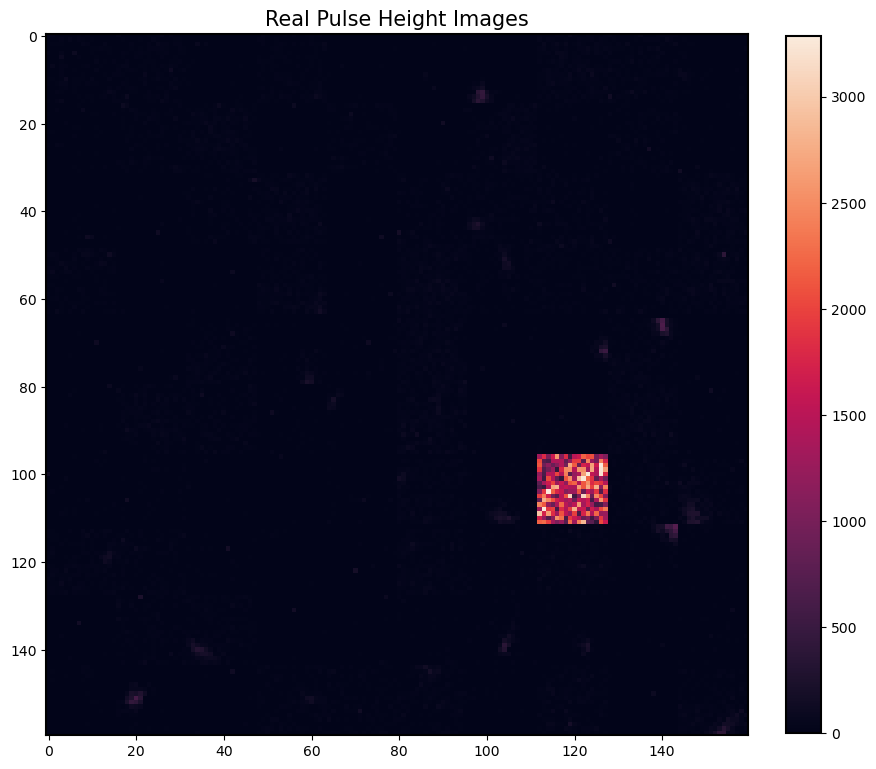

In [7]:
# Create pulse-height dataset instance for a specific observing run.

ph_dataset_config = {
    "max_ph_frames": 100_000,
    "observing_runs": [
        {
            "data_dir": './test_data',
            "run_dir": 'obs_Lick.start_2023-07-14T04:46:21Z.runtype_sci-obs.pffd',
            "module_ids": 'all',
        },
        {
            "data_dir": './test_data',
            "run_dir": 'obs_Lick.start_2023-09-14T04:25:43Z.runtype_sci-obs.pffd',
            "module_ids": 'all',
        },
        {
            "data_dir": './test_data',
            "run_dir": 'obs_Lick.start_2023-10-12T04:28:34Z.runtype_eng-test.pffd',
            "module_ids": 'all',
        },
        {
            "data_dir": './test_data',
            "run_dir": 'obs_Lick.start_2024-07-25T04:34:06Z.runtype_sci-data.pffd',
            "module_ids": 'all',
        },
    ]
}

transform = v2.Compose([
    v2.ToTensor(),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.ToDtype(torch.float),
])

ph_dataset = PulseHeightDataset(ph_dataset_config, transform=transform, log_level=logging.ERROR)
show_dataset_sample(ph_dataset, nrows=10, ncols=10)

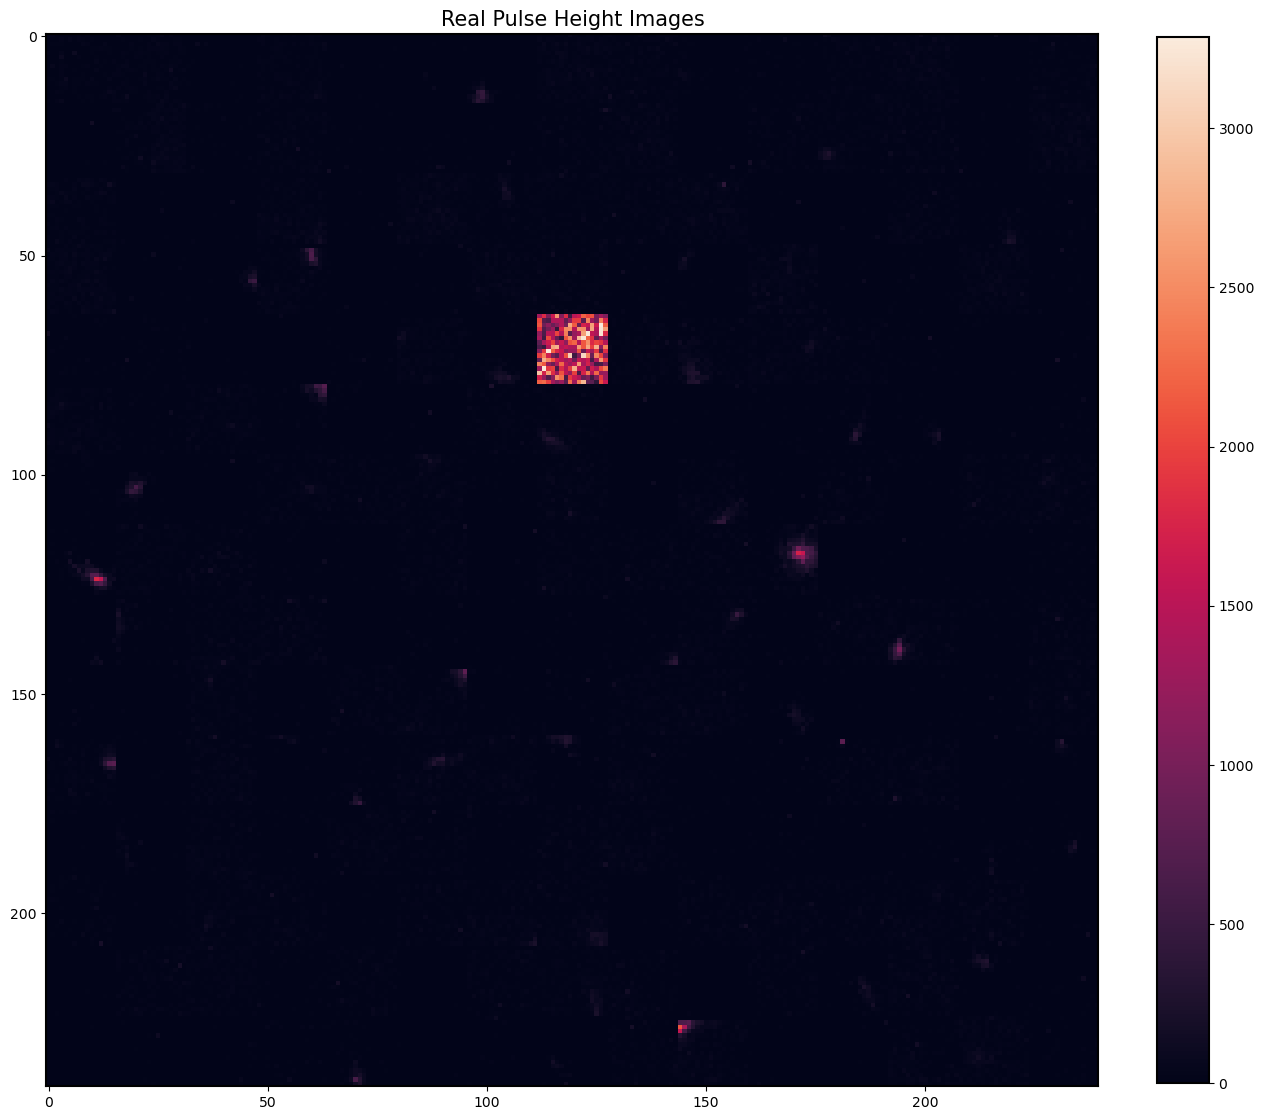

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.68batch/s]

Epoch 1

current lr =  [0.0001]


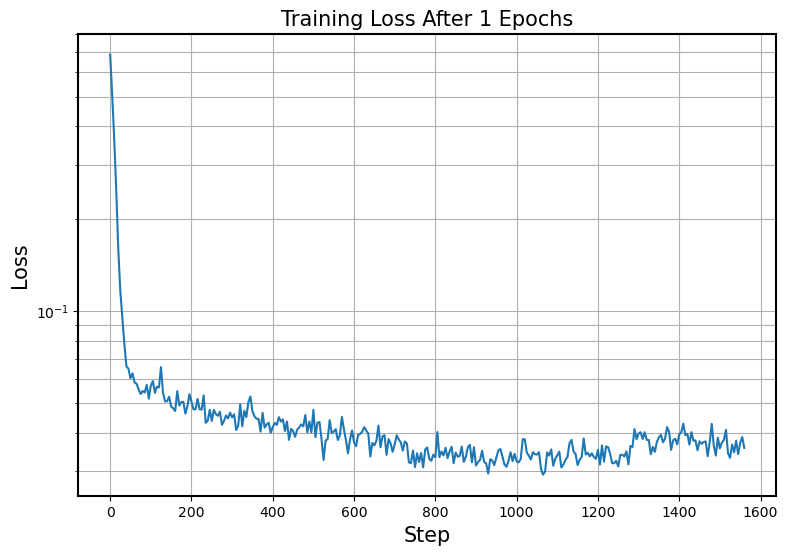

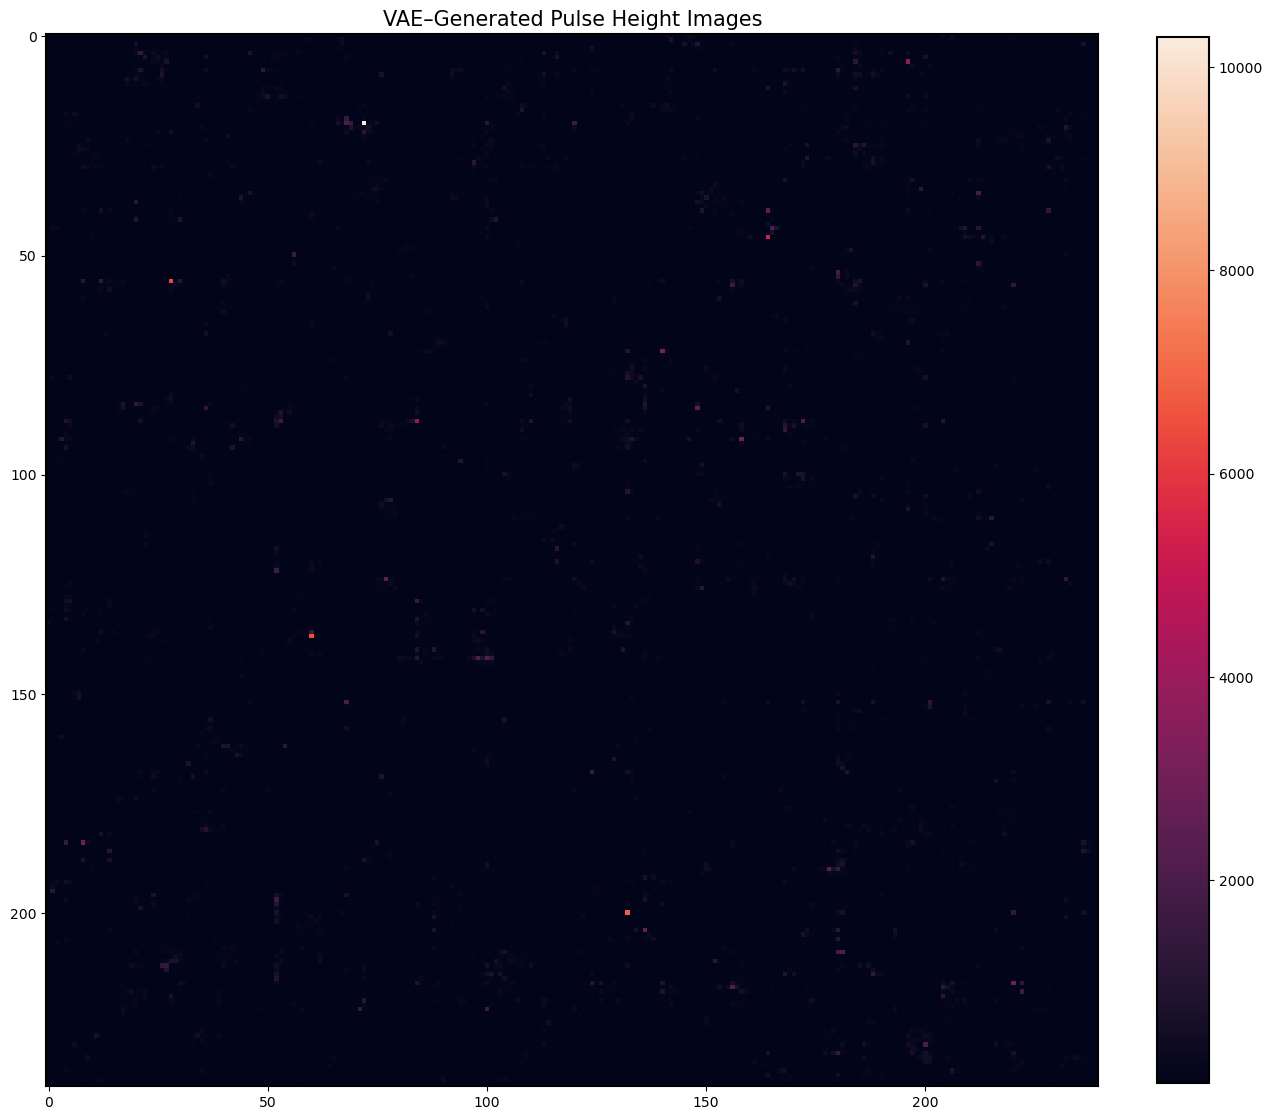

doing gmm with 8 components


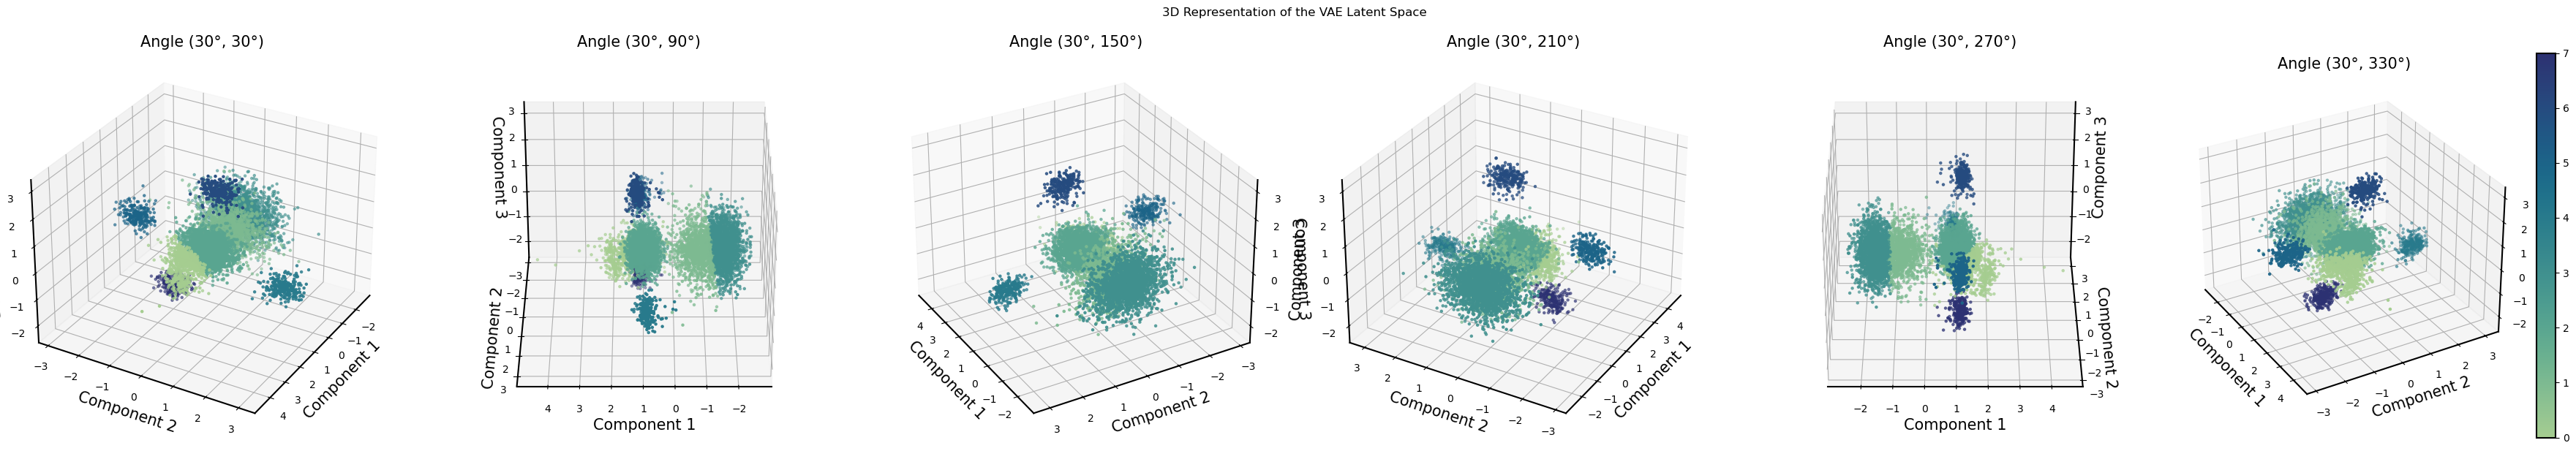

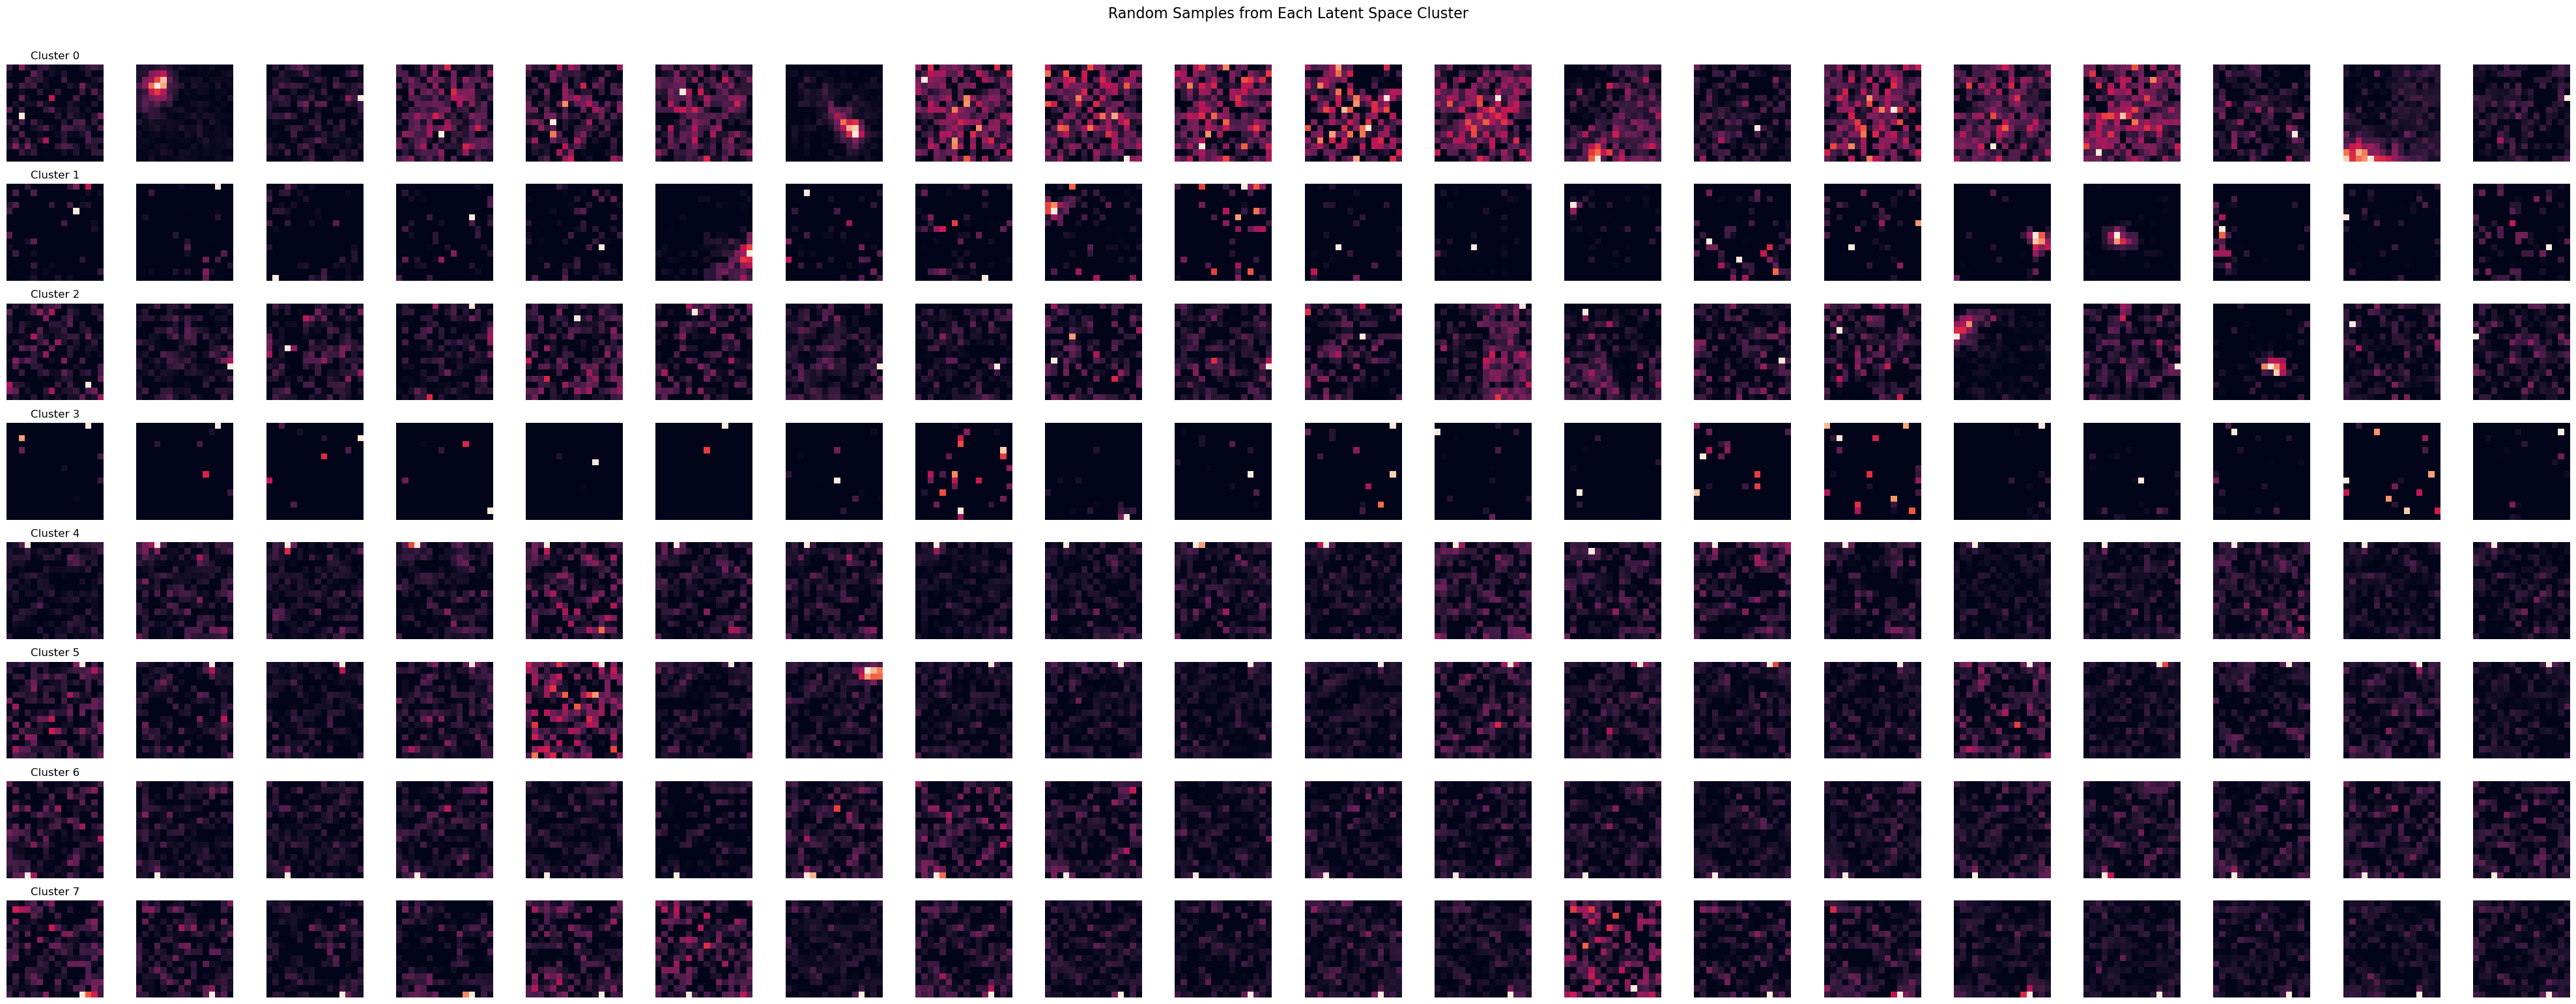

 51%|█████████████████████████████████████████████████████████████████████████▍                                                                       | 791/1563 [00:19<00:19, 39.69batch/s]

In [ ]:
train_config = {
    'model': BetaVAE,
    'hidden_dim': 84,
    'latent_dim': 24,
    'beta': 1e-6,
    'sparsity_weight': 1e-6,
    'num_epochs': 251,
    'batch_size': 64,
    'gamma': 1.0,
    'lr': 1e-4,
    'weight_decay': 0,
    'reduction_method': 'pca',
    'clustering_method': 'gmm',
    'n_clusters': 12,
    'max_gmm_components': 20,
}

model, log_df = train_vae(
    train_config,
    ph_dataset,
    seed = 13245,
    verbose = True
)